In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from itertools import product
import hdbscan
import seaborn as sns
import scipy.optimize as opt

In [2]:
def peak_grid(zero, v1, v2, xes, yes, delta, exclude = ()):
    zero = np.array(zero)
    v1 = np.array(v1)
    v2 = np.array(v2)
    coords = [zero + v1*x + v2*y + delta*np.random.randn(2) for (x, y) in product(xes, yes) if not (x, y) in exclude]
    return coords


def ring_filter(center, r1, r2):
    center = np.array(center)
    def f(pair):
        d = np.linalg.norm(center - pair)
        return (d > r1) and (d < r2)
    return f

def make_cartesian(polar):
    return np.array((np.cos(polar[1]), np.sin(polar[1]))) * polar[0]
    
def make_polar(cartesian):
    return np.array([np.linalg.norm(cartesian), np.arctan2(cartesian[1], cartesian[0])])
    
    
v = np.array([2, 3])

assert( np.sum(v - make_polar(make_cartesian(v))) < 0.001  )

In [3]:
f1 = ring_filter((0,0), 0, 3)

coords_1 = peak_grid((0,0), (0.7, 0.39), (0.7, -0.39), np.arange(-5, 5), np.arange(-5, 5), 0.01)
coords_1 = [p for p in coords_1 if f1(p)]
coords_1 = np.array(list(coords_1)).T

f2 = ring_filter((3,3), 3, 5)
f3 = ring_filter((0,0), 0, 2.5)
coords_2 = peak_grid((0,0), (0.5, 0.4), (0.3, -0.8), np.arange(-5, 5), np.arange(-5, 5), 0.01, ((0,0),))
coords_2 = [p for p in coords_2 if f2(p) and f3(p)]
coords_2 = np.array(list(coords_2)).T

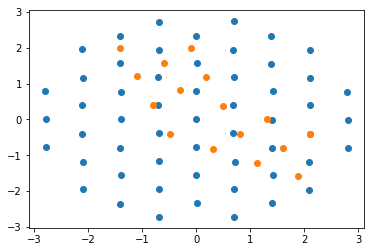

In [4]:
fig, axes = plt.subplots()
axes.scatter(coords_1[0], coords_1[1])
axes.scatter(coords_2[0], coords_2[1])

In [5]:
coords = np.concatenate((coords_1, coords_2), axis=1)
#coords = coords_1

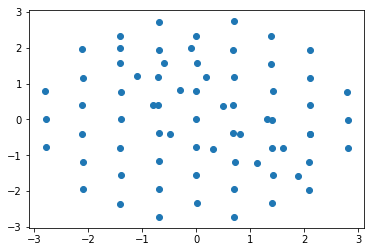

In [6]:
fig, axes = plt.subplots()
axes.scatter(coords[0], coords[1])

In [7]:
coords_T = coords.T

def make_polar_vectors(coords):
    result = []
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            delta = coords[j] - coords[i]
            (d, alpha) = make_polar(delta)
            result.append((d, alpha)) 
    return np.array(result)

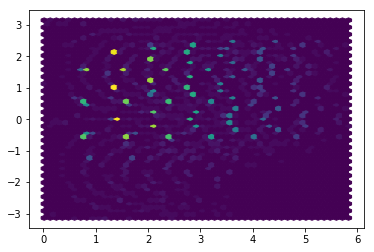

In [8]:
vectors = make_polar_vectors(coords_T)
fig, axes = plt.subplots()
axes.hexbin(vectors.T[0], vectors.T[1], gridsize=50)

[False False False ... False False False]


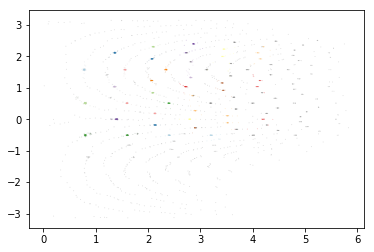

In [9]:
vectors = make_polar_vectors(coords_T)
clusterer = hdbscan.HDBSCAN(min_cluster_size=len(coords_T)//5, min_samples=30).fit(vectors)
print(clusterer.labels_ == 0)
color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*vectors.T, s=1, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [10]:
def candidates(points):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=max(2, len(points) // 5))
    vectors = make_polar_vectors(points)
    clusterer.fit(vectors)
    labels = clusterer.labels_
    cand = []
    for cluster in range(max(labels) + 1):
        selector = labels == cluster
        v = vectors[selector]
        weights = clusterer.probabilities_[selector]
        std = v.std(axis=0)
        fom = np.linalg.norm(std)
        if fom > 0.3:
            # print("too fuzzy")
            continue
        mean = np.average(v, axis=0, weights=weights)
        cand.append({
                'cluster': cluster, 
                 'mean': mean, 
                 'count': np.count_nonzero(selector), 
                 'mask': selector
        })
    # return the shortest candidate vectors
    return sorted(cand, key=lambda d: d['mean'][0])[:5]    

In [11]:
# Otherwise would be the brightest peak or user input
zero = np.array((0, 0))

# FIXME this function has a deep nested loop and is inefficient
def find_match(point, zero, a, b, max_index):
    for i in range(max_index):
        for j in range(max_index):
            for k in [1, -1]:
                for l in [1, -1]:
                    cand = zero + a*k*i + b*l*j
                    diff = point - cand
                    error = np.linalg.norm(diff)
                    if (error < 0.04):
                        return((k*i, l*j))
    return None


# FIXME this needs a more efficient implementation
# in particular the many calls to find_match()
def match_all(points, zero, a, b, max_index):
    matched = []
    matched_indices = []
    remainder = []
    for p in points:
        m = find_match(p, zero, a, b, max_index)
        if m is None:
            remainder.append(p)
        else:
            matched_indices.append(m)
            matched.append(p)
    return (np.array(matched), np.array(matched_indices), np.array(remainder))
        
def find_vector_match(points):
    cand = candidates(points)
    match_matrix = {}
    # we test all pairs of candidate vectors
    # amd polulate match_matrix
    for i in range(len(cand)):
        for j in range(i+1, len(cand)):
            a = cand[i]['mean']
            b = cand[j]['mean']
            angle_difference = abs(a[1] - b[1])
            if angle_difference < np.pi/5 or angle_difference > np.pi*4/5:
                # too collinear, not good lattice vectors
                continue
            a = make_cartesian(a)
            b = make_cartesian(b)
            match_matrix[(i, j)] = match_all(points, zero, a, b, 10)
    # we select the entry with highest number of matches
    candidate_index, match = sorted(match_matrix.items(), key=lambda d: len(d[1][1]), reverse=True)[0]
    a = make_cartesian(cand[candidate_index[0]]['mean'])
    b = make_cartesian(cand[candidate_index[1]]['mean'])
    
    return (a, b, match)

def optimize(a, b, matched, matched_indices):
    # Setting up index arrays to multiply with the vectors
    # There's probably a better way to do this.
    a_indices = matched_indices.T[0]
    a_indices = np.array((a_indices, a_indices)).T
    
    b_indices = matched_indices.T[1]
    b_indices = np.array((b_indices, b_indices)).T
    
    # The minimizer expects a flat array, so we disassemble the vectors
    a1, a2 = a
    b1, b2 = b

    def error_function(vec):
        a1, a2, b1, b2 = vec
        a = np.array((a1, a2))
        b = np.array((b1, b2))
        errors = matched - (a * a_indices + b * b_indices)
        error = (errors**2).sum()
        return error
    
    x0 = np.array((a1, a2, b1, b2))
    res = opt.minimize(error_function, x0=x0)
    
    a1, a2, b1, b2 = res.x
    new_a = np.array((a1, a2))
    new_b = np.array((b1, b2))

    return np.array((new_a, new_b))

def find_all_matches(points):
    matches = []
    while True:
        a, b, (matched, matched_indices, remainder) = find_vector_match(points)
        new_a, new_b = optimize(a, b, matched, matched_indices)
        matches.append((new_a, new_b, matched, matched_indices))
        # clustering with less than four points makes no sense
        # since that spans a grid by itself
        if len(remainder) < 4:
            break
        # no endless loops
        if len(remainder) == len(points):
            break
        points = remainder
    return (matches, remainder)


In [12]:
(matches, remainder) = find_all_matches(coords_T)

In [13]:
def calc_coords(a, b, matched_indices):
    a_indices = matched_indices.T[0]
    a_indices = np.array((a_indices, a_indices)).T
    
    b_indices = matched_indices.T[1]
    b_indices = np.array((b_indices, b_indices)).T
    return a * a_indices + b * b_indices

[-0.00143762  0.78087918] [0.69889776 0.38934262]
[0.49790415 0.40014838] [ 0.30311161 -0.80158123]


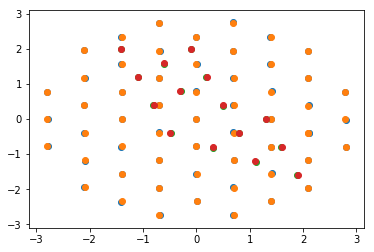

In [16]:
# TODO we can still do a better refinement of a and b now that we know all matches and indices
for (a, b, matched, matched_indices) in matches:
    print(a, b)
    plt.scatter(matched.T[0], matched.T[1])
    calc = calc_coords(a, b, matched_indices)
    plt.scatter(calc.T[0], calc.T[1])

In [15]:
if len(remainder) > 0:
    plt.scatter(remainder.T[0], remainder.T[1])
else:
    print("no remainder")

no remainder
